<a href="https://colab.research.google.com/github/tatianamgar/Work_GPN/blob/main/EDA_users.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from pathlib import Path

root_dir = os.path.abspath(os.getcwd())
root_dir = str(Path(root_dir).parent)
sys.path.append(root_dir)


import pandas as pd
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')


from constants import PATH_AUDIT_SEARCH, PATH_AUDIT_COPY, PATH_AUDIT_CARD
from src.data.make_dataset import read_file
from src.features.build_features import get_layer
from src.utils.helpers import get_window_df_by_query, get_window_df_by_ans_ids

Сначала подгрузим и обработаем небходимые данные

In [ ]:
# audit_search таблица
os.chdir('C:/Users/Mgar.TA/PycharmProjects/analytics-main')

search = read_file(PATH_AUDIT_SEARCH, sep='\t')
search = search[['date_time', 'page_number', 'query', 'username', 'answer', 'answer_ids']]

# убираем в audit_search пустые запросы
search = search.dropna()
# добавляем поле слоя поиска
search['activeLayer'] = get_layer(search, 'answer')
search.head()

In [ ]:
#оставляем выгрузку нужного периода - с 6 июня
search['date_time'] = pd.to_datetime(search['date_time'], format='ISO8601')
search = search[search['date_time'] > '2023-06-06']

In [ ]:
search_periods = search.set_index('date_time')
search_periods.username.resample('D').nunique()

date_time
2023-06-06    111
2023-06-07    120
2023-06-08    109
2023-06-09     87
2023-06-10     11
2023-06-11     10
2023-06-12      7
2023-06-13    128
Freq: D, Name: username, dtype: int64

Выгрузка с 4 июня

- запросы/действия без айдишников
- средние кол-ва айдишников

In [ ]:
# audit_copy таблица
copy = read_file(PATH_AUDIT_COPY, sep='\t')
# copy = copy[['action', 'username', 'page_number', 'page_size', 'query', 'date_time']]
copy['date_time'] = pd.to_datetime(copy['date_time'], format='ISO8601')
copy = copy[copy['date_time'] > '2023-06-06']
copy.head()

In [ ]:
# audit_card таблица
card = read_file(PATH_AUDIT_CARD, sep='\t')
# card = card[['username', 'query', 'date_time']]
# card['card'] = 'open card'
card['date_time'] = pd.to_datetime(card['date_time'], format='ISO8601')
card = card[card['date_time'] > '2023-06-06']
card.head(5)

> Аналитика и Визуализации

In [ ]:
#Сколько всего пользователей было в системе за последние 3 месяца
search['username'].nunique()

288

In [ ]:
# Количество пользователей в день
usersperday = search.groupby([search['date_time'].dt.date])['username'].nunique().reset_index()
usersperday['username'].describe()
# Интепретировать так: за 96 дней,
# в которых были хоть какие-то посещения пользователей, в среднем продукт посещали по 43 человека  в день

count      8.000000
mean      72.875000
std       53.903187
min        7.000000
25%       10.750000
50%       98.000000
75%      113.250000
max      128.000000
Name: username, dtype: float64

In [ ]:
#сколько запросов обработали аи и фуллтекст за 4 месяца
search['activeLayer'].value_counts()

activeLayer
fulltext    9745
ID          2014
AI           357
Name: count, dtype: int64

In [ ]:
search[search['activeLayer'] == 'AI']

<Axes: xlabel='date_time'>

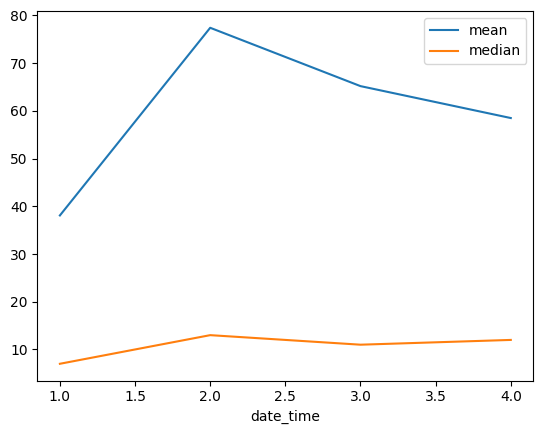

In [ ]:
# посмотрим на средние значения в количестве запросов
searchvis = search.groupby([search['date_time'].dt.month, search['username']])['query_string'].count().reset_index()
searchvis_mean = searchvis.groupby([searchvis['date_time']])['query_string'].mean().reset_index()
searchvis_median = searchvis.groupby([searchvis['date_time']])['query_string'].median().reset_index()
searchvis2 = pd.merge(searchvis_mean, searchvis_median, on='date_time')
searchvis2 = searchvis2.rename(columns={"query_string_x": "mean", "query_string_y": "median"})
pd.pivot_table(searchvis2, index = 'date_time', values = ['mean', 'median']).plot()

<Axes: xlabel='date_time', ylabel='query_string'>

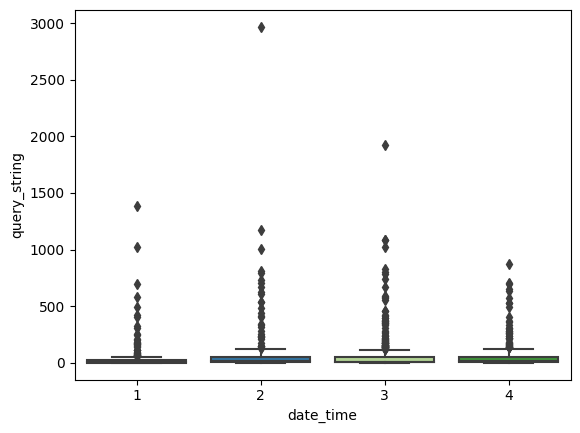

In [ ]:
searchvis = search.groupby([search['username'], search['date_time'].dt.month])['query_string'].count().reset_index()

sns.boxplot(x='date_time', y='query_string', data=searchvis, palette="Paired")

Судя по тому, что разрыв наблюдается между средним и медианным значениями, а также присутствуют внушительные выбросы на боксплоте, подтверждается гипотеза, что аномалии связаны с приходом группы людей или человека, совершивших нетипично большое количество запросов. В будущем можно посмотреть, сколько таких человек и на какие тематики запросы они совершают.

Посмотрим, с какой частотой разные слои поиска обрабатывали запросы пользователей в динамике за весь период времени выгрузки:

<Axes: xlabel='date_time'>

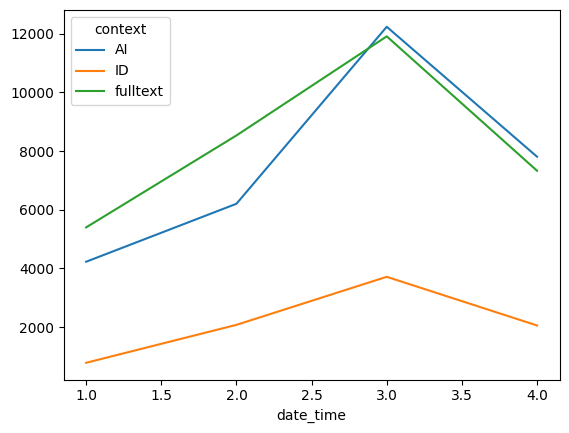

In [ ]:
vis5 = search.groupby([search['date_time'].dt.month, search['context']])['username'].count().reset_index()
pd.pivot_table(vis5, index = 'date_time', columns = 'context', values = 'username').plot()

**Копирования**

In [ ]:
vis2 = copy.groupby([copy['action']])['username'].nunique().reset_index()
fig = px.pie(vis2, values='username', names='action', title='Доли пользователей, совершивших хотя бы одно копирование за 3 месяца')
fig.show()

Среднее количество пользователей, совершающих копирования из карточки и поисковой выдачи в день:

<Axes: xlabel='action', ylabel='username'>

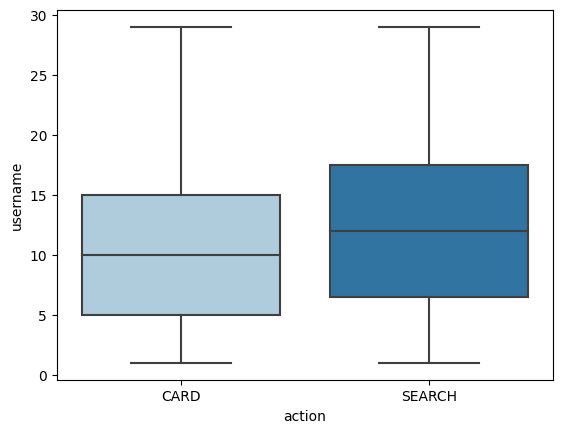

In [ ]:
copyvis_users = copy.groupby([copy['action'], copy['date_time'].dt.date])['username'].nunique().reset_index()

sns.boxplot(x='action', y='username', data=copyvis_users, palette="Paired")

Среднее количество действий копирования из карточки и поисковой выдачи в день:

<Axes: xlabel='action', ylabel='username'>

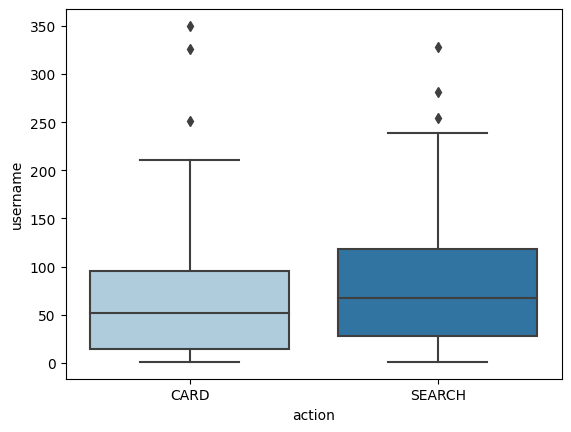

In [ ]:
copyvis = copy.groupby([copy['action'], copy['date_time'].dt.date])['username'].count().reset_index()

sns.boxplot(x='action', y='username', data=copyvis, palette="Paired")

In [ ]:
vis3 = copy.groupby([copy['action']])['username'].count().reset_index()
fig = px.pie(vis3, values='username', names='action', title='Доли копирований из карточки и выдачи')
fig.show()

Количество копирований из карточки и из выдачи по месяцам за последние 4 месяца:

<Axes: xlabel='date_time'>

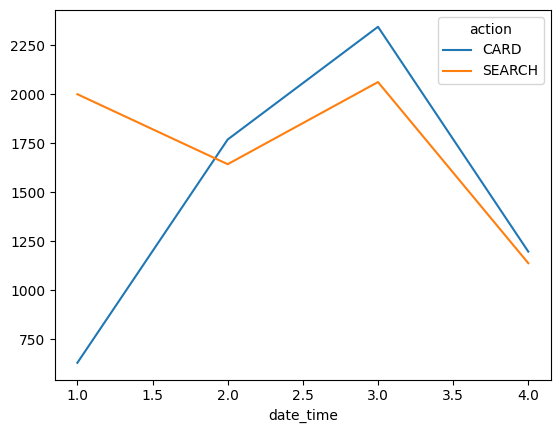

In [ ]:
vis4 = copy.groupby([copy['date_time'].dt.month, copy['action']])['username'].count().reset_index()
pd.pivot_table(vis4, index = 'date_time', columns = 'action', values = 'username').plot()

Посмотрим также в динамике частоту копирований из поисковой выдачи в зависимости от слоя поиска:

In [ ]:
#сначала подтянем запросы, из которых были совершены копирования, к копированиям, чтобы знать какие запросы учитывать
window_df = get_window_df_by_query(copy, search)
# window_df.head(5)

<Axes: xlabel='date_of_copy'>

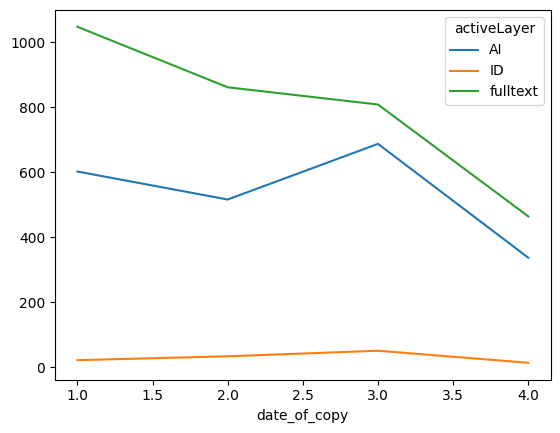

In [ ]:
vis5 = window_df.groupby([window_df['date_of_copy'].dt.month, window_df['activeLayer']])['username'].count().reset_index()
pd.pivot_table(vis5, index = 'date_of_copy', columns = 'activeLayer', values = 'username').plot()

**Открытия карточек**

In [ ]:
# количество пользователей, открывших карточку, за последние 4 месяца:
card['username'].nunique()

706

In [ ]:
# количество пользователей,свершающих копирование, в день - 43
ucardsperday = card.groupby([search['date_time'].dt.date])['username'].nunique().reset_index()
ucardsperday['username'].describe()

count     25.000000
mean      43.560000
std       37.174229
min        1.000000
25%        3.000000
50%       51.000000
75%       69.000000
max      104.000000
Name: username, dtype: float64

In [ ]:
win_df_cards = get_window_df_by_ans_ids(card, search)
win_df_cards.head(5)

In [ ]:
win_df_cards = win_df_cards[win_df_cards['date_of_opened_card']> win_df_cards['date_of_query']]

<Axes: xlabel='date_of_opened_card'>

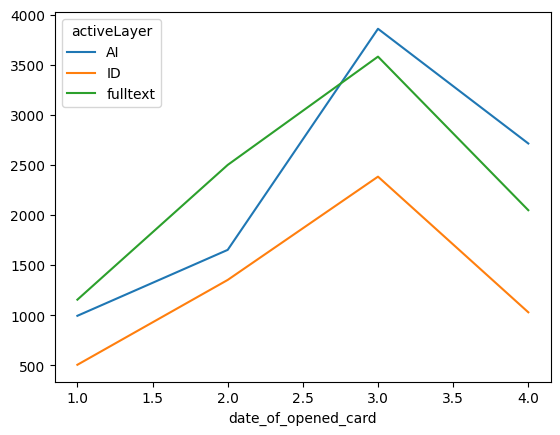

In [ ]:
# среднее количество запросов в месяц, в которых была открыта карточка, в динамике за 4 месяца в зависимости от слоя поиска
vis_cards = win_df_cards.groupby([win_df_cards['date_of_opened_card'].dt.month, win_df_cards['activeLayer']])['username'].count().reset_index()
pd.pivot_table(vis_cards, index = 'date_of_opened_card', columns = 'activeLayer', values = 'username').plot()

<Axes: xlabel='date_of_opened_card'>

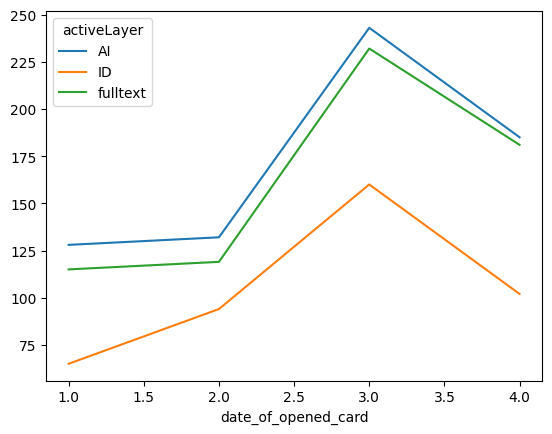

In [ ]:
# среднее количество пользователей в месяц, открывших карточки из поисковой выдачи, в динамике за 4 месяца в зависимости от слоя поиска:
vis_cards = win_df_cards.groupby([win_df_cards['date_of_opened_card'].dt.month, win_df_cards['activeLayer']])['username'].nunique().reset_index()
pd.pivot_table(vis_cards, index = 'date_of_opened_card', columns = 'activeLayer', values = 'username').plot()